<a href="https://colab.research.google.com/github/wakii/ML_Programming/blob/master/ex4-head-pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Getting and converting the data

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [12]:
path.ls()

[PosixPath('/root/.fastai/data/biwi_head_pose/11'),
 PosixPath('/root/.fastai/data/biwi_head_pose/04'),
 PosixPath('/root/.fastai/data/biwi_head_pose/14'),
 PosixPath('/root/.fastai/data/biwi_head_pose/23'),
 PosixPath('/root/.fastai/data/biwi_head_pose/18'),
 PosixPath('/root/.fastai/data/biwi_head_pose/01'),
 PosixPath('/root/.fastai/data/biwi_head_pose/08.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/13.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/20.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/09.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/09'),
 PosixPath('/root/.fastai/data/biwi_head_pose/08'),
 PosixPath('/root/.fastai/data/biwi_head_pose/06.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/19'),
 PosixPath('/root/.fastai/data/biwi_head_pose/07.obj'),
 PosixPath('/root/.fastai/data/biwi_head_pose/05'),
 PosixPath('/root/.fastai/data/biwi_head_pose/20'),
 PosixPath('/root/.fastai/data/biwi_head_pose/12.obj'),
 PosixPath('/root/.fastai/data/biwi_

In [13]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

- path/'01'/'rgb.cal'  text 값을 불러와 확인한다.

In [0]:
fname = '09/frame_00667_rgb.jpg'

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

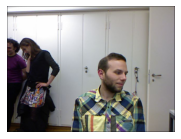

In [16]:
img = open_image(path/fname)
img.show()

In [17]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

- ImagePoints 는 pixel,segmentation 이 아닌 pixel의 x,y coordinates를 값으로 받는다.

In [19]:
get_ctr(fname)

tensor([263.9104, 428.5814])

- location
- regression으로 예측한 값


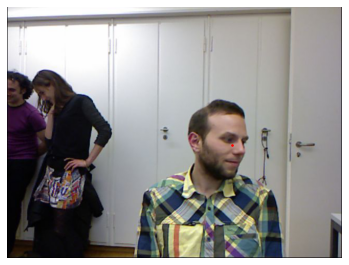

In [20]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

- 이미지의 center값들을 label을 붙여 databunch를 만든다.

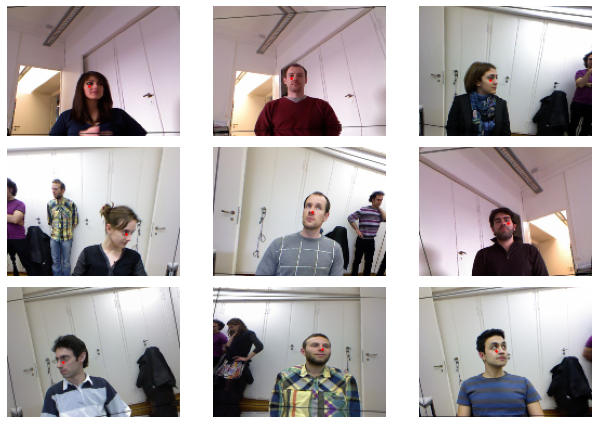

In [22]:
data.show_batch(3, figsize=(9,6))

## Train model

In [23]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


- classification 은 추정량이 추정치와 얼마나 비슷한지를 보여주는 척도로 loss function을 사용하는 반면
- Regression은 MSELossFunctions 사용한다.

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


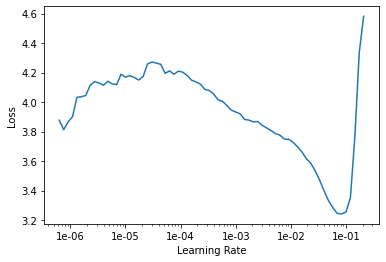

In [24]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [27]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,time
0,0.117499,0.041082,02:55
1,0.035179,0.006043,02:53
2,0.014218,0.004310,02:53
3,0.009374,0.003427,02:53


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

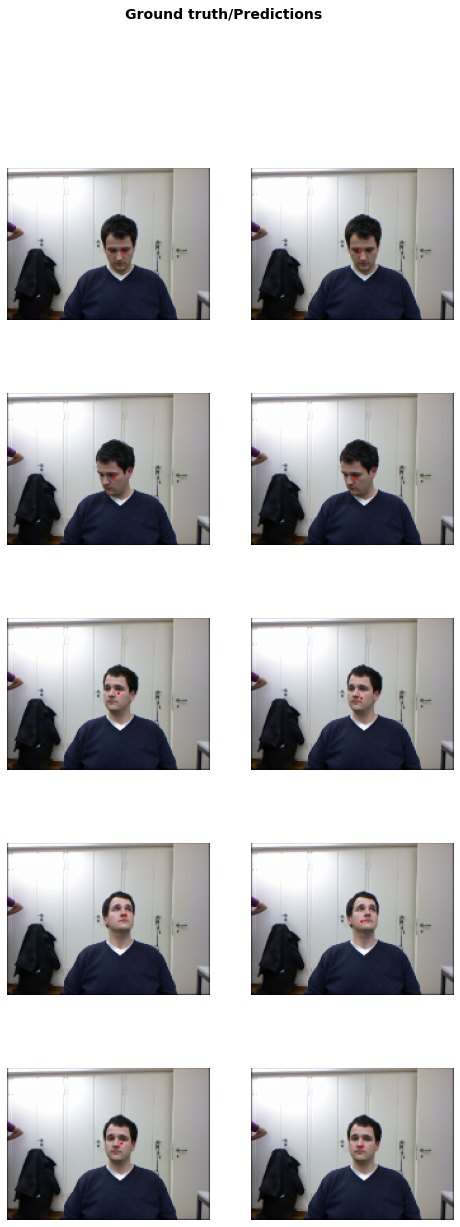

In [29]:
learn.show_results()

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

- transformation을 처리한 databunch

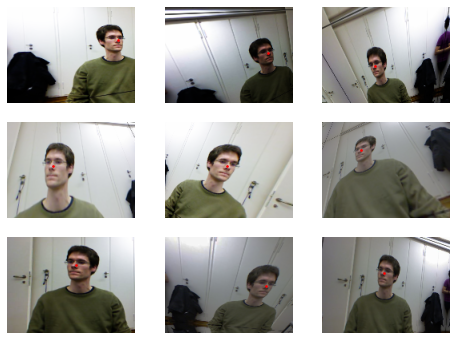

In [31]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))